In [10]:
import numpy as np
import os
from mfp_utils import *
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import *
import torch
import matplotlib.pyplot as plt

In [11]:
log_dir = 'results/mnist_mnist/CL_OT=0'

X_train_1   = torch.load(os.path.join(log_dir, '_train_P1.t'))
X_train_2   = torch.load(os.path.join(log_dir, '_train_P2.t'))
X_sample_01 = torch.load(os.path.join(log_dir, '_sample_trajectory_P0P1.t')).cpu().numpy()
X_sample_12 = torch.load(os.path.join(log_dir, '_sample_trajectory_P1P2.t')).cpu().numpy()

In [12]:
X_sample_1 = X_sample_01[:,-1,:]
X_sample_2 = X_sample_12[:,-1,:]

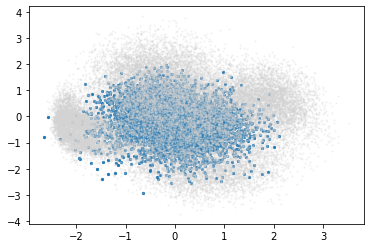

In [13]:
# dimensionality reduction for samples in P1
pca_P1 = PCA(n_components=2)
pca_P1.fit(X_train_1)

X_train_1_transformed  = pca_P1.transform(X_train_1)
X_sample_1_transformed = pca_P1.transform(X_sample_1)

# plot training data in P1 vs. samples from H_P0
plt.scatter(X_sample_1_transformed[:,0], X_sample_1_transformed[:,1], marker='o', s=5)
plt.scatter(X_train_1_transformed[:,0], X_train_1_transformed[:,1], marker='.', color='lightgrey', s=5, alpha=0.2)
plt.show()

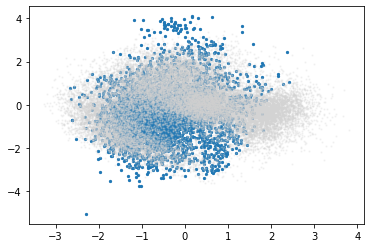

In [14]:
# dimensionality reduction for samples in P1
pca_P2 = PCA(n_components=2)
pca_P2.fit(X_train_2)

X_train_2_transformed  = pca_P2.transform(X_train_2)
X_sample_2_transformed = pca_P2.transform(X_sample_2)

# plot training data in P1 vs. samples from H_P0
plt.scatter(X_sample_2_transformed[:,0], X_sample_2_transformed[:,1], marker='o', s=5)
plt.scatter(X_train_2_transformed[:,0], X_train_2_transformed[:,1], marker='.', color='lightgrey', s=5, alpha=0.2)
plt.show()

In [15]:
import torch
import torch.nn as nn

In [16]:
class MLP(nn.Module):
    def __init__(self, d_in):
        super(MLP, self).__init__()
        d_h = 16
        self.net = nn.Sequential(
            nn.Linear(d_in, d_h),
            nn.ReLU(),
            nn.Linear(d_h, d_in)
        )
    
    def forward(self, x):
        return self.net(x)

In [17]:
d_in  = 2
net   = MLP(d_in)


x = torch.rand(4,d_in)
y = net(x)

In [18]:
import torchvision.models as models
from torch.autograd.functional import vhp

# Utilities to make nn.Module functional
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

def make_functional(mod):
    orig_params = tuple(mod.parameters())
    # Remove all the parameters in the model
    names = []
    for name, p in list(mod.named_parameters()):
        del_attr(mod, name.split("."))
        names.append(name)
    return orig_params, names

def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        # use this when loading the weights into a model container for vhp computation
        if not as_params: 
            set_attr(model, name.split("."), p)
        # use this when loading the weights back into the model as a nn.Module
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

In [19]:
N = 10
device = torch.device('cuda')
model  = MLP(d_in).to(device)
criterion = torch.nn.MSELoss()

inputs = torch.rand([N, d_in], device=device)
target = torch.rand([N, d_in], device=device)

# used for VJP
v_1 = model(inputs) - inputs

# make NN a pure function
params, names = make_functional(model)
# Make params regular Tensors instead of nn.Parameter
params = tuple(p.detach().requires_grad_() for p in params)

def nn_fun(*new_params):
    load_weights(model, names, new_params, as_params=False)
    out = model(inputs)

    return out

def loss_fun(*new_params):
    load_weights(model, names, new_params, as_params=False)
    out = model(inputs)

    loss = criterion(out, target)
    return loss

# VJP, output should have the same shape as the parameters.
out, a = vhp(nn_fun, params, v_1)

# the vector you want to product H with
v_2 = tuple(p.detach().clone().requires_grad_() for p in params)
# out is L(input;theta), i.e. the loss value. a is the vhp product. It should have the same shape as the parameters.
out, a = vhp(loss_fun, params, v_2)

RuntimeError: v is a tuple of invalid length: should be 4 but got 1.

In [ ]:
v_1.shape

torch.Size([10, 2])

In [ ]:
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x = torch.load('./results/crowd_motion_gaussian/NSF_CL_crowd_motion_2D_Jeff_OT_1e-1_F_2e-1_B=2048_lr=1e-3_N=50k_FD4Simp/train_traj_crowd_motion_gaussian.pt')

X_train, X_val = train_test_split(x, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(X_train, test_size=0.2/0.8, random_state=42)

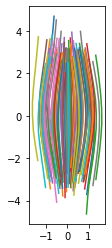

In [21]:
for i in range(100):
    plt.plot(X_train[i,:,0], X_train[i,:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.distributions as D


class Obstacle_true():
    def __init__(self, device):
        super(Obstacle_true, self).__init__()
        self.device = device
        self.construct_obstacle()
        
    def construct_obstacle(self):
        mean = torch.zeros(2).to(self.device)
        diag = torch.Tensor([1., 0.5]).to(self.device)
        cov  = torch.diag_embed(diag)
        self.B = D.MultivariateNormal(mean, cov)

    def eval(self, x):
        return self.B.log_prob(x[..., :2])


class Obstacle(nn.Module):
    def __init__(self, d_in):
        super(Obstacle, self).__init__()
        h = 128
        self.net = nn.Sequential(
            nn.Linear(d_in, h),
            nn.ReLU(),
            nn.Linear(h, 1)
        )
    
    def forward(self, x):
        return self.net(x)



In [10]:
device = torch.device('cuda')

d_in = 2
N = 10000
B = 32

obs_true = Obstacle_true(device)
obs = Obstacle(d_in).to(device)
optimizer = torch.optim.Adam(obs.parameters())

for i in range(N):
    x = 8. * torch.rand(B, 2) - 4.
    x = x.to(device)

    optimizer.zero_grad()
    loss = torch.sum((obs(x).reshape(-1) - obs_true.eval(x))**2, dim=-1).mean()
    loss.backward()
    optimizer.step()

    print ("Loss value: {:.2f}".format(float(loss)))





Loss value: 2903.20
Loss value: 3590.53
Loss value: 3682.87
Loss value: 4473.08
Loss value: 3742.33
Loss value: 4157.78
Loss value: 3463.35
Loss value: 2750.21
Loss value: 2597.85
Loss value: 3083.98
Loss value: 3916.53
Loss value: 3160.07
Loss value: 4003.31
Loss value: 4346.60
Loss value: 3083.03
Loss value: 3727.35
Loss value: 2418.52
Loss value: 5182.91
Loss value: 2476.04
Loss value: 2932.22
Loss value: 3400.23
Loss value: 3037.69
Loss value: 2107.23
Loss value: 3326.56
Loss value: 2654.35
Loss value: 2014.55
Loss value: 2468.49
Loss value: 2055.46
Loss value: 3736.04
Loss value: 2001.25
Loss value: 2117.85
Loss value: 3557.80
Loss value: 2315.24
Loss value: 2678.43
Loss value: 2164.42
Loss value: 3212.60
Loss value: 2503.30
Loss value: 2322.64
Loss value: 2210.77
Loss value: 2240.58
Loss value: 2448.35
Loss value: 2036.12
Loss value: 2078.45
Loss value: 1779.14
Loss value: 1874.04
Loss value: 2453.60
Loss value: 1663.41
Loss value: 1845.50
Loss value: 2092.53
Loss value: 1882.36


In [6]:
import optuna, pickle

save_path = './results/crowd_motion_gaussian_bilevel/optuna_test/plot_data/optuna_study.pkl'
study = pickle.load(open(save_path, "rb" ))

In [10]:
study.trials[0]

FrozenTrial(number=0, value=7.9704694747924805, datetime_start=datetime.datetime(2022, 9, 26, 12, 27, 31, 475114), datetime_complete=datetime.datetime(2022, 9, 26, 12, 27, 55, 515126), params={'lr_obs': 0.025606092822414245, 'lr_NF': 0.0008110659670632603, 'inner_iter': 10, 'optimizer_inner': 'adam', 'scheduler_obs': 'cyclic', 'l2_reg_obs': 7.047299105423898e-07, 'act_obs': 'elu', 'NF_grad_clip': False}, distributions={'lr_obs': LogUniformDistribution(high=0.1, low=0.001), 'lr_NF': LogUniformDistribution(high=0.001, low=0.0001), 'inner_iter': IntUniformDistribution(high=10, low=1, step=1), 'optimizer_inner': CategoricalDistribution(choices=('adam', 'sgd')), 'scheduler_obs': CategoricalDistribution(choices=('adaptive', 'cyclic', 'step')), 'l2_reg_obs': LogUniformDistribution(high=1e-05, low=1e-08), 'act_obs': CategoricalDistribution(choices=('tanh', 'elu', 'softplus')), 'NF_grad_clip': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={

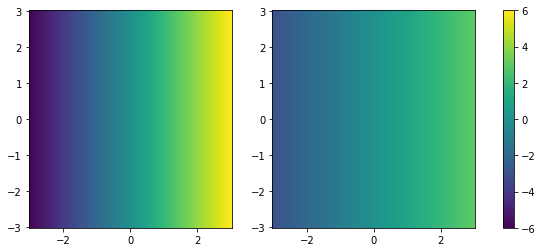

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# the function to be plotted
def func(x,y):    
    # gives vertical color bars if x is horizontal axis
    return x

import pylab

# define the grid over which the function should be plotted (xx and yy are matrices)
xx, yy = pylab.meshgrid(
    pylab.linspace(-3,3, 101),
    pylab.linspace(-3,3, 111))

# indexing of xx and yy (with the default value for the
# 'indexing' parameter of meshgrid(..) ) is as follows:
#
#   first index  (row index)    is y coordinate index
#   second index (column index) is x coordinate index
#
# as required by pcolor(..)

# fill a matrix with the function values
zz = pylab.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = func(xx[i,j], yy[i,j])

zz2 = zz * 2

# plot the calculated function values
fig = plt.figure(figsize=(10, 4))
sub_fig1 = fig.add_subplot(121)
vmin = np.min(np.minimum(zz2, zz))
vmax = np.max(np.maximum(zz2, zz))
pylab.pcolor(xx,yy,zz2, shading='auto', vmin=vmin, vmax=vmax)
# and a color bar to show the correspondence between function value and color
# pylab.colorbar()

sub_fig2 = fig.add_subplot(122)
pylab.pcolor(xx,yy,zz, shading='auto', vmin=vmin, vmax=vmax)
# and a color bar to show the correspondence between function value and color
pylab.colorbar(ax=[sub_fig1, sub_fig2])

pylab.show() 

In [38]:
import torch

def f(x):
    return torch.exp(x).sum()

x = torch.ones(2,1).double().requires_grad_()

y = f(x)
y.backward()

In [39]:
x.grad

tensor([[2.7183],
        [2.7183]], dtype=torch.float64)

In [41]:
d = 1e-6
e_1 = torch.zeros_like(x)
e_1[0] = 1.

e_2 = torch.zeros_like(x)
e_2[1] = 1.

g_FD_1 = (f(x + d*e_1) - f(x)) / d
g_FD_2 = (f(x + d*e_2) - f(x)) / d

[g_FD_1, g_FD_2]

[tensor(2.7183, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2.7183, dtype=torch.float64, grad_fn=<DivBackward0>)]

In [55]:
import torch
import torch.nn as nn
import copy


def grad_FD(model, x, loss_orig, d=1e-6):
    g_FD = []
    NF_copy  = copy.deepcopy(model)

    # for i in range(len(obstacle.parameters())):
    # print ("Obs param at the start: {}".format(list(obstacle.parameters())[0]))
    with torch.no_grad():
        for k,p in enumerate(model.parameters()):
            size = p.numel()
            g = torch.zeros_like(p)
            for j in range(size):
                NF_copy  = copy.deepcopy(model)
                e = torch.zeros_like(p).flatten()
                e[j] = 1.

                # loss_orig = compute_loss(NF_copy, x, args, mode='train')['loss']
                p_copy = 
                p_copy.data = p_copy.data + d * e.reshape(p.shape)
                loss_perturbed = NF_copy(x).mean()

                g = g.flatten()
                g[j] = (loss_perturbed - loss_orig) / d
            
            g_FD.append(g.reshape(p.shape))

    return g_FD





In [56]:
d_in = 3
h = 4

x = torch.rand(2, d_in).double().requires_grad_()
model = nn.Sequential(
    nn.Linear(d_in, h),
    nn.ReLU(),
    nn.Linear(h, 1)
)

model = model.double()

d_list = [10**(-i) for i in range(4,9)]
diff_list = []
rel_diff_list = []
G_FD_list = []

loss = model(x).mean()
loss.backward()
G = [p.grad.data for p in model.parameters()]

for d in d_list:
    G_FD = grad_FD(model, x, loss, d=d)

    norm_AD = torch.sqrt(sum([torch.sum(g**2) for g in G])) 
    g_diff = [g_AD - g_FD for (g_AD, g_FD) in zip(G, G_FD)]
    norm_diff = torch.sqrt(sum([torch.sum(g**2) for g in g_diff]))
    norm_rel_diff = norm_diff / norm_AD
    diff_list.append(float(norm_diff))
    rel_diff_list.append(float(norm_rel_diff))
    G_FD_list.append(G_FD)

UnboundLocalError: local variable 'NF_copy' referenced before assignment

In [54]:
g_diff

[tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.1602e-09, 1.0523e-01, 1.9028e-01],
         [3.3080e-01, 3.3080e-01, 3.3080e-01]], dtype=torch.float64),
 tensor([0.3308, 0.3308, 0.3308, 0.4732], dtype=torch.float64),
 tensor([[ 0.4732,  0.4732,  0.4732, -0.8659]], dtype=torch.float64),
 tensor([-0.8659], dtype=torch.float64)]

In [2]:
import torch.nn as nn
import torch

model = nn.Sequential(
    nn.Linear(2, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)

model2 = nn.Sequential(
    nn.Linear(2, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)


d  = model.state_dict()
d2 = model2.state_dict()


In [3]:
d

OrderedDict([('0.weight',
              tensor([[-0.3415, -0.6502],
                      [-0.2683, -0.5535],
                      [ 0.5694,  0.3924],
                      [-0.2575,  0.0334],
                      [-0.0678, -0.4382],
                      [ 0.3535,  0.1139],
                      [-0.1945,  0.5908],
                      [ 0.3804, -0.0205],
                      [ 0.1624,  0.1613],
                      [ 0.6778, -0.3618],
                      [ 0.1346, -0.5979],
                      [-0.2030, -0.3226]])),
             ('0.bias',
              tensor([ 0.1904,  0.5326,  0.4692,  0.3986, -0.2128, -0.5820, -0.4277,  0.0006,
                       0.2988, -0.3094, -0.1673, -0.3348])),
             ('2.weight',
              tensor([[-0.0242, -0.0093,  0.2718, -0.2553,  0.1491,  0.1526,  0.0419, -0.1421,
                        0.2536,  0.2129, -0.0911, -0.2771]])),
             ('2.bias', tensor([-0.2757]))])

In [ ]:
import torch
from mfp_utils import *
from arguments import *

d = 2

args = parse_arguments()

obs = Obstacle(d, args).to(device)
obs_true = Obstacle_true(args, device)

pretrain_obs_dir = 'results/crowd_motion_gaussian_two_bars_uniform/F=2e-1/pretrain_obs.t'
obs.load_state_dict(torch.load(pretrain_obs_dir))
print ("Loaded obstacle from: {}".format(pretrain_obs_dir))
for p in obs.parameters():
    p.data = p.data + args.pretrain_obs_eps * torch.rand_like(p)

grid, grid_pad, grid_x, grid_y, dx = create_grid_for_eval(args, d)
grid = grid.to(device)
grid_pad = grid_pad.to(device)

